In [44]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import Table

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_excel('Dataset.xlsx')

## Clean Data

In [3]:
# Get the list of columns to convert to categorical
categorical_columns = df.select_dtypes(include='int64').columns.tolist()

# Convert the selected columns to categorical
df[categorical_columns] = df[categorical_columns].astype('category')

numeric_data = df.select_dtypes(include=[np.number])

# Calculate MAD for each column
mad = numeric_data.mad()

# Choose a threshold multiplier
k = 3

# Calculate the threshold value
threshold = k * mad

# Identify outliers
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Apply logarithm to the specified columns
outlier_columns = ['CommissionSacrificePercentage', 'BonusCommissionPercentage']
for column in outlier_columns:
    df[column] = np.log1p(df[column])

numeric_data = df.select_dtypes(include=[np.number])

# Check that all outliers have been handled
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Count the number of outliers in each column
outlier_counts = outliers.sum()

# Create a new DataFrame from outlier_counts
outlier_table = pd.DataFrame({'Column': outlier_counts.index, 'Outlier Count': outlier_counts.values})

# Display the table
print(outlier_table)

                          Column  Outlier Count
0  CommissionSacrificePercentage              0
1      BonusCommissionPercentage              0


## Feature Importance Techniques

### Random Forest Feature Importance Scoring

In [4]:
# Define features and target variable
features = ['Product', 'ProductGroup', 'ProductType', 'Agency', 'WorkflowStatus', 'Indexation', 'NoOfLives',
            'CommDateProvided', 'PaymentFreq', 'UWDecision', 'ComissionSacrifice', 'CommissionSacrificeType',
            'RenewalSacrificeType', 'CommissionTerms', 'Discount', 'BonusCommission', 'FreeCover',
            'SeriousIllnessType', 'SignedDecReceived']
target = 'PolicyIssued'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

# Print feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
Agency                     0.559780
WorkflowStatus             0.173468
UWDecision                 0.118432
CommDateProvided           0.033788
SignedDecReceived          0.013722
NoOfLives                  0.013316
ProductGroup               0.011579
SeriousIllnessType         0.011124
BonusCommission            0.011008
Product                    0.010811
CommissionTerms            0.010571
Indexation                 0.009274
ProductType                0.006298
RenewalSacrificeType       0.004066
CommissionSacrificeType    0.003736
ComissionSacrifice         0.003247
Discount                   0.002656
PaymentFreq                0.002633
FreeCover                  0.000490
dtype: float64


In [5]:
# Select the top-n features based on importance
n = 4 
selected_features = feature_importances[:n].index.tolist()

In [6]:
# Create a new dataset with the selected features
selected_data = df[selected_features + [target]]

In [7]:
# Conduct experiments by training and evaluating the model on different feature combinations
for feature_combination in range(1, n + 1):
    selected_features_combination = selected_features[:feature_combination]
    X_train_combination = X_train[selected_features_combination]
    X_test_combination = X_test[selected_features_combination]

    rf_classifier_combination = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_combination.fit(X_train_combination, y_train)
    y_pred_combination = rf_classifier_combination.predict(X_test_combination)

    accuracy = accuracy_score(y_test, y_pred_combination)
    report = classification_report(y_test, y_pred_combination)
    print(f"\nExperiment with {feature_combination} features:")
    print(f"Selected Features: {selected_features_combination}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")


Experiment with 1 features:
Selected Features: ['Agency']
Accuracy: 0.779639462054494
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.03      0.06      6973
           1       0.78      0.99      0.88     24480

    accuracy                           0.78     31453
   macro avg       0.67      0.51      0.47     31453
weighted avg       0.73      0.78      0.69     31453


Experiment with 2 features:
Selected Features: ['Agency', 'WorkflowStatus']
Accuracy: 0.7996057609766953
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.35      0.44      6973
           1       0.83      0.93      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.71      0.64      0.66     31453
weighted avg       0.78      0.80      0.78     31453


Experiment with 3 features:
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision']
Accuracy: 0.8020

#### Try different test sizes and different n estimators

In [8]:
# Define different test sizes and n estimator values to test
test_sizes = [0.2, 0.25, 0.3, 0.33]
n_estimators_values = [50, 100, 150, 200]
n_values = [4,5,6,7]

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Random Forest classifier with the current n estimator value
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Print feature importances for the current test size and n estimator value
        print(f"\nTest Size: {test_size}, n_estimators: {n_estimators_value}")
        print("Feature Importances:")
        print(feature_importances)

        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
            rf_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = rf_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            report = classification_report(y_test, y_pred_selected)
            print(f"Selected Features: {selected_features}")
            print(f"Accuracy: {accuracy}")
            print(f"Classification Report:\n{report}")


Test Size: 0.2, n_estimators: 50
Feature Importances:
Agency                     0.560283
WorkflowStatus             0.171679
UWDecision                 0.117542
CommDateProvided           0.036348
NoOfLives                  0.014011
SignedDecReceived          0.013423
ProductGroup               0.012310
Product                    0.011039
BonusCommission            0.010791
SeriousIllnessType         0.010695
CommissionTerms            0.010358
Indexation                 0.009120
ProductType                0.005754
RenewalSacrificeType       0.003982
CommissionSacrificeType    0.003621
ComissionSacrifice         0.003282
Discount                   0.002636
PaymentFreq                0.002599
FreeCover                  0.000528
dtype: float64
Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided']
Accuracy: 0.8017359234413252
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      6973
   

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided']
Accuracy: 0.8017995103805678
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      6973
           1       0.84      0.93      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.71      0.65      0.66     31453
weighted avg       0.78      0.80      0.78     31453

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'NoOfLives']
Accuracy: 0.8006867389438209
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      6973
           1       0.84      0.92      0.88     24480

    accuracy                           0.80     31453
   macro avg       0.71      0.65      0.67     31453
weighted avg       0.78      0.80      0.78     31453

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'Co

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'NoOfLives']
Accuracy: 0.8013277037338488
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.39      0.46      8650
           1       0.84      0.92      0.88     30666

    accuracy                           0.80     39316
   macro avg       0.71      0.65      0.67     39316
weighted avg       0.78      0.80      0.79     39316

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'NoOfLives', 'SignedDecReceived']
Accuracy: 0.7971055041204599
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.39      0.46      8650
           1       0.84      0.91      0.88     30666

    accuracy                           0.80     39316
   macro avg       0.70      0.65      0.67     39316
weighted avg       0.78      0.80      0.78     39316

Selected Features: ['Agency', '

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives']
Accuracy: 0.7963288751351236
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.40      0.46     10413
           1       0.84      0.91      0.87     36766

    accuracy                           0.80     47179
   macro avg       0.70      0.65      0.67     47179
weighted avg       0.78      0.80      0.78     47179

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'BonusCommission']
Accuracy: 0.7916021958922402
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.40      0.46     10413
           1       0.84      0.90      0.87     36766

    accuracy                           0.79     47179
   macro avg       0.69      0.65      0.67     47179
weighted avg       0.77      0.79      0.78   

Selected Features: ['Agency', 'WorkflowStatus', 'UWDecision', 'CommDateProvided', 'SignedDecReceived', 'NoOfLives', 'ProductGroup']
Accuracy: 0.7922037882729253
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.40      0.46     11494
           1       0.84      0.90      0.87     40403

    accuracy                           0.79     51897
   macro avg       0.69      0.65      0.67     51897
weighted avg       0.77      0.79      0.78     51897


Test Size: 0.33, n_estimators: 100
Feature Importances:
Agency                     0.564858
WorkflowStatus             0.175017
UWDecision                 0.108815
CommDateProvided           0.033528
SignedDecReceived          0.013987
NoOfLives                  0.013651
SeriousIllnessType         0.011698
BonusCommission            0.011642
ProductGroup               0.011488
Product                    0.011156
CommissionTerms            0.010968
Indexation                 0.009743


In [9]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Random Forest classifier with the current n estimator value
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualization
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances

        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
            rf_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = rf_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))

In [10]:
results

[(0.2, 50, 4, 0.8017359234413252),
 (0.2, 50, 5, 0.8019902711982959),
 (0.2, 50, 6, 0.7962674466664547),
 (0.2, 50, 7, 0.7925794041903793),
 (0.2, 100, 4, 0.8023717928337519),
 (0.2, 100, 5, 0.7976345658601723),
 (0.2, 100, 6, 0.7953772295170572),
 (0.2, 100, 7, 0.7927701650081074),
 (0.2, 150, 4, 0.8016723365020825),
 (0.2, 150, 5, 0.8009092932311703),
 (0.2, 150, 6, 0.7958541315613773),
 (0.2, 150, 7, 0.7927065780688647),
 (0.2, 200, 4, 0.8017995103805678),
 (0.2, 200, 5, 0.8006867389438209),
 (0.2, 200, 6, 0.7955044033955425),
 (0.2, 200, 7, 0.7921978825549232),
 (0.25, 50, 4, 0.8027520602299318),
 (0.25, 50, 5, 0.8012768338589887),
 (0.25, 50, 6, 0.7967748499338692),
 (0.25, 50, 7, 0.7933156984433818),
 (0.25, 100, 4, 0.8030318445416624),
 (0.25, 100, 5, 0.8016837928578696),
 (0.25, 100, 6, 0.7974107233696205),
 (0.25, 100, 7, 0.7931376538813715),
 (0.25, 150, 4, 0.8031590192288127),
 (0.25, 150, 5, 0.8013277037338488),
 (0.25, 150, 6, 0.7971055041204599),
 (0.25, 150, 7, 0.7921965

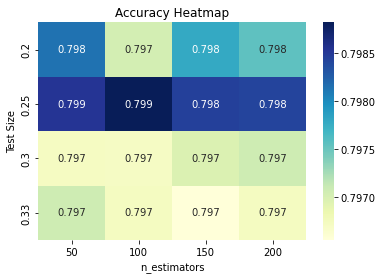

In [21]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

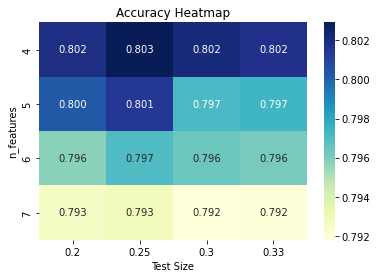

In [22]:
# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

In [27]:
feature_importance_stats = {}
for feature in features:
    feature_importance_stats[feature] = {
        'Min': min(importance[feature] for importance in feature_importances_dict.values()),
        'Max': max(importance[feature] for importance in feature_importances_dict.values()),
        'Mean': sum(importance[feature] for importance in feature_importances_dict.values()) / len(feature_importances_dict),
        'Median': pd.Series([importance[feature] for importance in feature_importances_dict.values()]).median()
    }

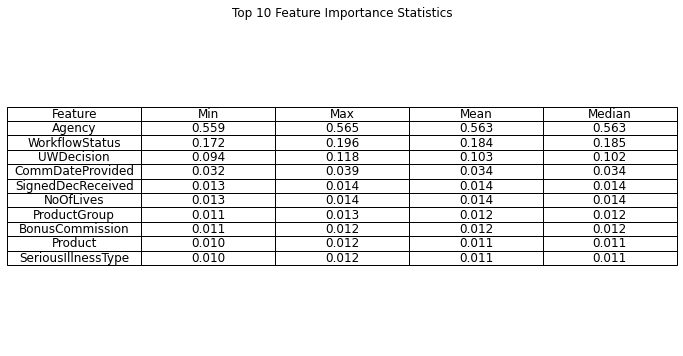

In [38]:
# Create a DataFrame from feature importance statistics
feature_importance_stats_df = pd.DataFrame(feature_importance_stats).T

# Sort features by Mean importance and select top 10
top_10_features = feature_importance_stats_df.sort_values(by='Mean', ascending=False).head(10)

# Define statistics and colors
statistics = ['Min', 'Max', 'Mean', 'Median']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a table of feature importance statistics
table_data = []
for feature, row in top_10_features.iterrows():
    row_values = [f"{row[stat]:.3f}" for stat in statistics]
    table_data.append([feature] + row_values)

table = ax.table(cellText=table_data, colLabels=['Feature'] + statistics, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax.axis('off')

ax.set_title('Top 10 Feature Importance Statistics')

plt.show()

The feature importance scoring built into random forest appears to be suggesting that the same four independent variables as identifed with Cramer's V are the most important predictors of Policy Issuance.

### Gradient Boosting Feature Importance Scoring

In [45]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Gradient Boosting classifier
        gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
        gb_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(gb_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualization
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances
        
        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            gb_classifier_selected = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
            gb_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = gb_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))

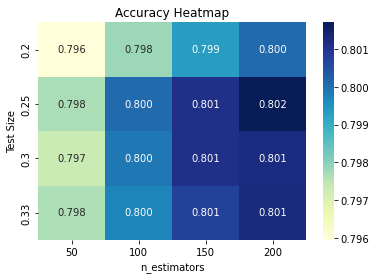

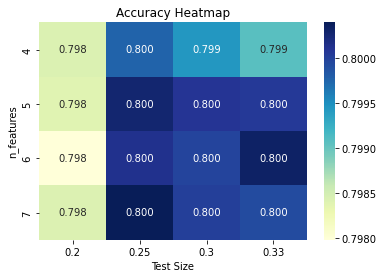

In [46]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

In [47]:
feature_importance_stats = {}
for feature in features:
    feature_importance_stats[feature] = {
        'Min': min(importance[feature] for importance in feature_importances_dict.values()),
        'Max': max(importance[feature] for importance in feature_importances_dict.values()),
        'Mean': sum(importance[feature] for importance in feature_importances_dict.values()) / len(feature_importances_dict),
        'Median': pd.Series([importance[feature] for importance in feature_importances_dict.values()]).median()
    }

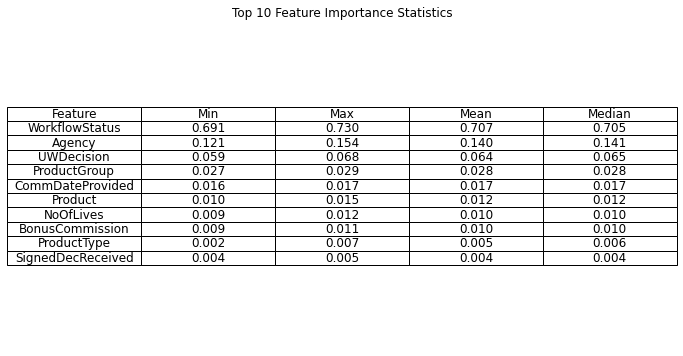

In [48]:
# Create a DataFrame from feature importance statistics
feature_importance_stats_df = pd.DataFrame(feature_importance_stats).T

# Sort features by Mean importance and select top 10
top_10_features = feature_importance_stats_df.sort_values(by='Mean', ascending=False).head(10)

# Define statistics and colors
statistics = ['Min', 'Max', 'Mean', 'Median']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a table of feature importance statistics
table_data = []
for feature, row in top_10_features.iterrows():
    row_values = [f"{row[stat]:.3f}" for stat in statistics]
    table_data.append([feature] + row_values)

table = ax.table(cellText=table_data, colLabels=['Feature'] + statistics, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax.axis('off')


ax.set_title('Top 10 Feature Importance Statistics')

plt.show()

### LightGBM Feature Importance Scoring

In [66]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a LightGBM classifier
        lgb_classifier = lgb.LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
        lgb_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(lgb_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualisation
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances
        
        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            lgb_classifier_selected = lgb.LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
            lgb_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = lgb_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))

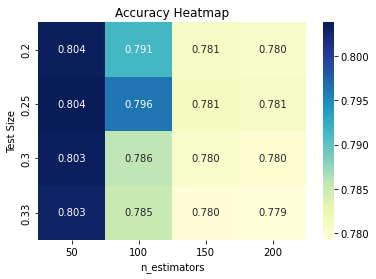

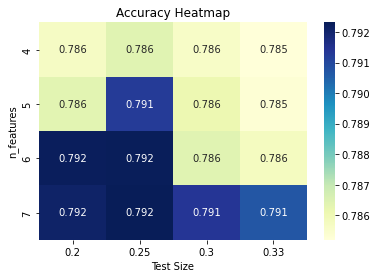

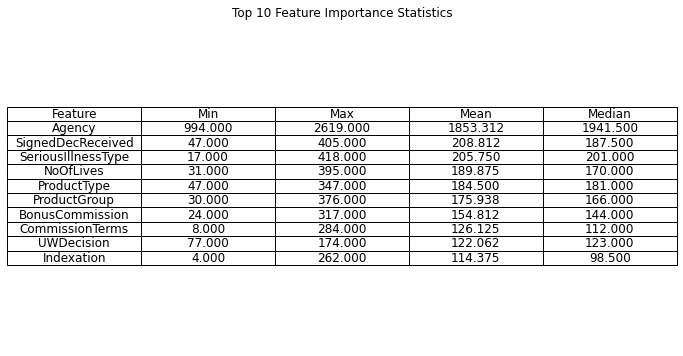

In [67]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

feature_importance_stats = {}
for feature in features:
    feature_importance_stats[feature] = {
        'Min': min(importance[feature] for importance in feature_importances_dict.values()),
        'Max': max(importance[feature] for importance in feature_importances_dict.values()),
        'Mean': sum(importance[feature] for importance in feature_importances_dict.values()) / len(feature_importances_dict),
        'Median': pd.Series([importance[feature] for importance in feature_importances_dict.values()]).median()
    }
    
# Create a DataFrame from feature importance statistics
feature_importance_stats_df = pd.DataFrame(feature_importance_stats).T

# Sort features by Mean importance and select top 10
top_10_features = feature_importance_stats_df.sort_values(by='Mean', ascending=False).head(10)

# Define statistics and colors
statistics = ['Min', 'Max', 'Mean', 'Median']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a table of feature importance statistics
table_data = []
for feature, row in top_10_features.iterrows():
    row_values = [f"{row[stat]:.3f}" for stat in statistics]
    table_data.append([feature] + row_values)

table = ax.table(cellText=table_data, colLabels=['Feature'] + statistics, cellLoc='center', loc='center')


table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax.axis('off')
ax.set_title('Top 10 Feature Importance Statistics')

plt.show()

#### Class Aware Feature Importance

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
df = df.drop(columns=['PropDate'])

In [21]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

In [22]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Scaler anf Borderline SMOTE used in order to avoid the introduction of unrealistic sythetic data points

In [25]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [27]:
# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [28]:
# Calculate feature importance scores
feature_importance = rf_classifier.feature_importances_

In [29]:
# Calculate class-specific importance
class_labels = df['PolicyIssued'].unique()
class_importance = {}
for label in class_labels:
    mask = (y_train_resampled == label)
    class_importance[label] = feature_importance * mask.mean()

In [30]:
# Combine class-specific importance using weights based on class distribution
class_distribution = y_train_resampled.value_counts(normalize=True)
weighted_importance = sum(class_importance[label] * class_distribution[label] for label in class_labels)


In [32]:
# Print the weighted importance scores for each feature in descending order
importance_scores = [(feature_name, importance_score) for feature_name, importance_score in zip(X.columns, weighted_importance)]
importance_scores_sorted = sorted(importance_scores, key=lambda x: x[1], reverse=True)

for feature_name, importance_score in importance_scores_sorted:
    print(f"Feature: {feature_name}, Weighted Importance: {importance_score:.4f}")


Feature: Agency, Weighted Importance: 0.2151
Feature: WorkflowStatus, Weighted Importance: 0.1172
Feature: UWDecision, Weighted Importance: 0.0374
Feature: BonusCommissionPercentage, Weighted Importance: 0.0323
Feature: CommissionSacrificePercentage, Weighted Importance: 0.0300
Feature: CommDateProvided, Weighted Importance: 0.0253
Feature: SignedDecReceived, Weighted Importance: 0.0092
Feature: NoOfLives, Weighted Importance: 0.0073
Feature: CommissionTerms, Weighted Importance: 0.0042
Feature: SeriousIllnessType, Weighted Importance: 0.0040
Feature: Indexation, Weighted Importance: 0.0037
Feature: Product, Weighted Importance: 0.0034
Feature: ProductGroup, Weighted Importance: 0.0023
Feature: BonusCommission, Weighted Importance: 0.0017
Feature: RenewalSacrificeType, Weighted Importance: 0.0013
Feature: CommissionSacrificeType, Weighted Importance: 0.0011
Feature: ProductType, Weighted Importance: 0.0010
Feature: Discount, Weighted Importance: 0.0010
Feature: ComissionSacrifice, Weig

### Recursive Feature Elimination with Cross-Validation

#### Random Forest

In [41]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)


Selected features:
Agency
WorkflowStatus


The result "Selected features: Agency, WorkflowStatus" indicates that the algorithm determined that the two features "Agency" and "WorkflowStatus" are the most important features for predicting the target variable ("PolicyIssued") after applying Recursive Feature Elimination with Cross-Validation (RFECV) on the resampled dataset.

Agency is expected to have a significant predictive value in deciding whether or not a policy will be issued. It implies that the agency linked with the application has a significant impact on the conversion of life assurance applications.

WorkflowStatus element is also crucial in predicting the outcome.

The fact that just these two features were chosen shows that the other features did not contribute as much to the prediction of the target variable, according to the RFECV algorithm. This might imply that these two features include the most essential information for predicting policy issuance.

#### GradientBoostingClassifier

In [42]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a GradientBoostingClassifier on the resampled data
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=gb_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)

Selected features:
ProductGroup
Agency
WorkflowStatus
NoOfLives
CommDateProvided
UWDecision
BonusCommissionPercentage
SignedDecReceived


Agency and WorkflowStatus identified as importantant features, similar to RandomForest RFE.

ProductGroup, NoOfLives, BonusCommissionPercentage, and SignedDecReceived also worth consideration - similar to GBC analysis on imbalanced dataset.

#### LightGBM

In [45]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a LightGBM classifier on the resampled data
lgb_classifier = LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=lgb_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)

Selected features:
Product
Agency
WorkflowStatus
Indexation
NoOfLives
CommDateProvided
UWDecision
CommissionSacrificePercentage
CommissionTerms
BonusCommissionPercentage
SignedDecReceived


Similar to the above with the exception of Indexation, CommissionSacrificePercentage and CommissionSacrificePercentage

### Feature Selection Conclusions

Agency and WorkflowStatus occur in the majority of the analyses, implying that they are the most essential variables for predicting the conversion of life assurance apps. UWDecision and CommDateProvided might also be considered because they occur consistently in various techniques. These features might serve as a solid starting point for developing a predictive model. 